In [1]:
import glob
import os
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import deque

import re

from datetime import datetime
from datetime import timedelta
from datetime import date

## Load Data

In [3]:
# make a variable with a root directory path
# then have relative path

In [26]:
#This assumes results are 1 level down from root directory

data_directory = '/home/kel2158/Projects/COVIDHerit/data/'
results_directory = '/home/kel2158/Projects/COVIDHerit/results/12_29_21'


#NYC wide hospitalizations and case data from https://www1.nyc.gov/site/doh/covid/covid-19-data-totals.page

nyc_covid_hosp_file = data_directory + 'hosp-by-day.csv'
nyc_covid_cases_file = data_directory + 'cases-by-day.csv'
fam_size_file = data_directory +'/12_29_21/fam_size.txt'


In [27]:
fam_size_df = pd.read_csv(fam_size_file,sep=" ")

pheno2sampsize = dict(zip( fam_size_df["pheno"],fam_size_df["famcount"] ))

In [7]:
#This assumes results are 1 level down from root directory
import glob
results = deque()
incomplete_row = deque()


for file_path in glob.glob(f'{results_directory}/*/*results.csv', recursive=True):
    file_name = file_path.split("/")[-1]
#     print(file_name)
    
    with open(file_path) as f:   
        reader = csv.reader(f, delimiter='\t')
        
        try:

            header= next(reader)
            header = header[0].split(",")

            for row in reader:
                row_split = row[0].split(",")
                row_split.append(file_name)

                if len(row_split) == 14:
                    results.append(row_split )
                else:
                    incomplete_row.append(row_split )

        except:
            continue
            

for file_path in glob.glob(f'{results_directory}/*/*/*results.csv', recursive=True):
    file_name = file_path.split("/")[-1]
#     print(file_name)
    
    with open(file_path) as f:   
        reader = csv.reader(f, delimiter='\t')
        
        try:

            header= next(reader)
            header = header[0].split(",")

            for row in reader:
                row_split = row[0].split(",")
                row_split.append(file_name)

                if len(row_split) == 14:
                    results.append(row_split )
                else:
                    incomplete_row.append(row_split )

        except:
            continue

In [8]:
header.append("file_name")

#Create dataframe with results
solar_df = pd.DataFrame(results,columns=header)

#Process Data

#Turn into floats and ints from strings
for col in ['estimate', 'estimate_lower','estimate_upper', 'solarerr', 'solarpval','posa']:
    solar_df[col].update( solar_df[col].astype(float) )
    
    
solar_df["num_families"].update( solar_df["num_families"].astype(int))


clean_model_name = {"ACE_h2o":"Heritability","ACE_Shared_Env":"Shared Environment",
                   "AE":"AE"}
solar_df["model_orig"] = solar_df["model"].copy()
solar_df["model_clean"] = solar_df["model"].map(clean_model_name)

In [9]:
file = nyc_covid_cases_file
nyc_case_df = pd.read_csv(file)

file = nyc_covid_hosp_file
nyc_df = pd.read_csv(file)

In [10]:
#get in datetime
pull_date_from_nycases = lambda date: datetime.strptime(date, '%m/%d/%Y' ).date()

nyc_df["date_cln"] = nyc_df["date_of_interest"].apply(pull_date_from_nycases)
nyc_case_df["date_cln"] = nyc_case_df["date_of_interest"].apply(pull_date_from_nycases)

In [11]:
#Get the weeks
pull_date_from_trait = lambda trait: datetime.strptime(trait.replace("covid_cswitch_weekly_",""), '%m_%d_%Y' ).date()

weeks = list( set( solar_df[ solar_df["trait"].str.contains("covid_cswitch_weekly_") ]\
                  ["trait"].apply(pull_date_from_trait) ))

weeks.sort()

In [119]:
nyc_case_df["date_cln"][0]

datetime.date(2020, 2, 29)

datetime.date(2021, 2, 14)

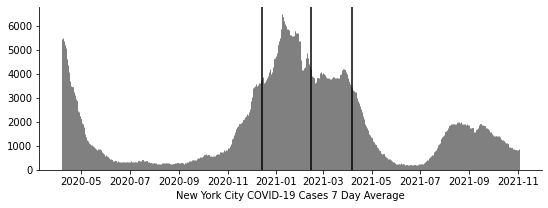

In [131]:
#Used in manuscript
fig, axs= plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(9, 3)

adm_plt = axs.bar(nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        ]["date_cln"], 
                  
                  nyc_case_df[ (nyc_case_df["date_cln"] >= weeks[0]) &
                        (nyc_case_df["date_cln"] <= weeks[-1] + timedelta(days=7))
                        
                        ]["ALL_CASE_COUNT_7DAY_AVG"], width=0.1,\
                  color="white",edgecolor='grey')


axs.set_xlabel("New York City COVID-19 Cases 7 Day Average")

sns.despine()

plt.axvline(x = datetime(2020, 12, 14).date(), color = 'black', label = '1st vaccination in NYC ')
plt.axvline(x = datetime(2021, 2, 14).date(), color = 'black', label = 'Vaccines available to patients with underlying conditions')
plt.axvline(x = datetime(2021, 4, 6).date(), color = 'black', label = 'Vaccines available to patients 16+')




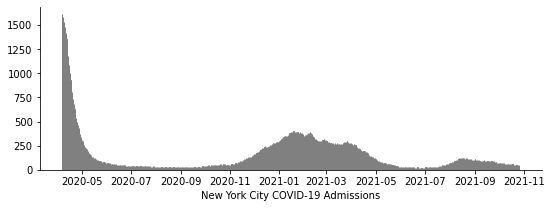

In [13]:

fig, axs= plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(9, 3)
#Get 2 plots, first will be heritability estimates, second is fam size



adm_plt = axs.bar(nyc_df[ (nyc_df["date_cln"] >= weeks[0]) &
                        (nyc_df["date_cln"] <= weeks[-1])
                        ]["date_cln"], 
                  
                  nyc_df[ (nyc_df["date_cln"] >= weeks[0]) &
                        (nyc_df["date_cln"] <= weeks[-1])
                        
                        ]["HOSP_COUNT_7DAY_AVG"], width=0.1,\
                  color="white",edgecolor='grey')


# for label in axs.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)

axs.set_xlabel("New York City COVID-19 Admissions")

sns.despine()

## Functions

In [15]:
plt.rc("axes.spines", top=False, right=False)

In [16]:
regex = r'(\d+_\d+_\d+)'

pull_date = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%Y-%m-%d').date()

pull_date_window = lambda trait_name: datetime.strptime(re.findall(regex, trait_name)[0]\
                                                 ,'%m_%d_%Y').date()

In [109]:
#Function to map the colors as a list from the input list of x variables
def pltcolor(posas):
    cols=[]
    for posa in posas:
        if posa< 0.2:
            cols.append('red')
        elif posa<0.8:
            cols.append('orange')
        else:
            cols.append('green')
    
    return cols

In [100]:
def pull_graph_vals(df, model, x):
    lower_err = df_holder[ df_holder["model"] == model ]["estimate"] -\
                df_holder[ df_holder["model"] == model ]["estimate_lower"]
    
    upper_err = df_holder[ df_holder["model"] == model ]["estimate_upper"] - \
                df_holder[ df_holder["model"] == model ]["estimate"]
    
    err = [lower_err,upper_err]
    
    x = df_holder[ df_holder["model"] == model ][x]
    y = df_holder[ df_holder["model"] == model ]["estimate"]
    
    posa_color = pltcolor(df_holder[ df_holder["model"] == model ]["posa"])
    
    num_fams = df_holder[ df_holder["model"] == model ]\
    ["num_families"].astype(int).values
    
    return( err,x,y,posa_color,num_fams )

In [101]:
def autolabel(rects, ax):
    """
    Attach a text label above each bar displaying its height
    """
    for num, rect in enumerate(rects):
        height = rect.get_height()
        #If there are a whole bunch of labels only include every third
        if len ( rects ) >= 12:
            if num % 5 == 0:
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')
        
        
        #Otherwise include all labels
        else:
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')


In [111]:
def create_graph (df, x_value_col, plot_title, model_type="ace", hide_error=False ,use_fam=True, remove_scatter_markers=False):   
    
    fig, axs= plt.subplots(nrows=2,ncols=1,gridspec_kw={'height_ratios': [3, 1]})
    fig.set_size_inches(9, 6)
    
    #Get 2 plots, first will be heritability estimates, second is fam size
    ax1 = axs[0]
    ax2 = axs[1]
    
    if model_type == "ace":
        model_lst =  ['Heritability', 'Shared Environment', ]
        
    elif model_type == "ae" :
        model_lst = ['AE']
    
    else:
        model_type == "all"
        model_lst = ['Heritability', 'Shared Environment', 'AE']
    
    num_fams_lst = list()
    for model in model_lst:

        #pull data from dataframe
        err,x,y, posa_color,num_fams = pull_graph_vals(df, model , x_value_col )
        
        # plot posa color for marker for heritability/shared env

        if remove_scatter_markers:
             p1 = ax1.scatter(x=x,y=y,c=posa_color, s=0.001)
        
        else:
            p1 = ax1.scatter(x=x,y=y,c=posa_color)
        
        
        ax1.set_ylabel( "Estimate")
        
        #include error bars or not
        if hide_error:
            ax1.errorbar(x, y, linestyle='--',  
            elinewidth=0.4, label=model)
            
        else:
            p2 = ax1.errorbar(x, y, yerr=err, linestyle='--',  
            elinewidth=0.4, label=model)
            
            ax1.set_ylim([0, 1])
        
        ax1.legend(frameon=False)
        

        num_fams_lst.extend( list(zip(x, num_fams)) )

        
        
    #Needs to align with percent family        
    if x_value_col != "date":
        bar_width = 0.09

    #Needs to align
    else:
        bar_width = 5

    fam_df = pd.DataFrame( num_fams_lst, columns=[x_value_col,"num_fams"]).sort_values(by=x_value_col)
    
    fam_df.drop_duplicates(inplace=True)
    
    if use_fam:
        #create bar graph for family sizes
        rec = ax2.bar(fam_df[x_value_col], fam_df["num_fams"], width=bar_width, color="white",edgecolor='grey')
        ax2.set_ylabel("Number of Families")

        if x_value_col != "date":
            ax2.set_xlabel("Percent Families Included")

        else:
            ax2.set_xlabel("Date Cutoff")
        
        #put in labels above bar graphs
        autolabel(rec,ax2)


    fig.suptitle(plot_title)
    plt.show()
    sns.despine(fig)


    return(fig,axs)



## ID Top

In [22]:
#Get lsit of all phenotypes in results
phenos_lst = solar_df["trait"].unique()

#Finds phenos in df that contains these words (really groupings of phenos)

phenos = ["covid","covid_noproband","days_hosp","hosp_stat","hosp_stat_nopro",\
                   "covid_highdeg_fam","covid_highdeg_nopro"
                   
                  ]

interesting_cols=["trait","num_families","model","estimate","estimate_lower",
                  "estimate_upper","posa"]

## Get reporting estimates

In [23]:
trait_maxposa_df =solar_df[solar_df["model"] == "ACE_h2o"].groupby(["trait"]).\
agg({ "posa":"max"}).reset_index()

top_posa_df = pd.merge(trait_maxposa_df, solar_df, how='left', left_on=['trait','posa'], right_on = ['trait','posa'])

#Limit to those that aren't cummulative or weekly
top_posa_df = top_posa_df[ ~top_posa_df["trait"].str.contains("window|weekly",regex=True )]
reporting_cols = ["trait","model","estimate","estimate_lower","estimate_upper","posa","num_converged","num_significant","num_families"]

In [105]:
models = [ "ACE_h2o","ACE_Shared_Env"  ]

best_est_list = list()
lowqual_ests = list()
missing_ests = list()

for pheno in phenos:
    for model in models:
        #First get above 80% posas
        holder_df = solar_df[( solar_df["trait"] == pheno ) & 
            (solar_df["model"] == model) &
             ( solar_df["posa"] > 0.8 )
            ].sort_values(by="num_families")
        
        #If we have no estimate with a posa over 0.8, use highest estimate we have
        if len(holder_df) == 0:
            
            holder_df = top_posa_df[ (top_posa_df["trait"] == pheno) &
           (top_posa_df["model"] == model)
           ]
        
        else:
            #Else pick the estimate with posa above 0.3 with fewest number of families to limit ascertainment bias
            holder_df = holder_df[ holder_df["num_families"] == holder_df["num_families"].min() ]

        if len(holder_df) > 0:
            best_est_list.append(holder_df)
        
        else:
            missing_ests.append((pheno,model))
        
best_est_dfs = pd.concat(best_est_list) 
best_est_dfs["total_samp"] = best_est_dfs["trait"].map(pheno2sampsize)


In [29]:
best_est_dfs

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file_name,model_orig,model_clean,total_samp
494,covid,ALL,529,ACE_h2o,0.649664,0.330907,0.79607,0.07632,0.000022,200,190,160,0.842105,V4I8A_solar_strap_results.csv,ACE_h2o,Heritability,1324
495,covid,ALL,529,ACE_Shared_Env,0.350336,0.151995,0.507414,0.07632,0.000008,200,190,160,0.842105,V4I8A_solar_strap_results.csv,ACE_Shared_Env,Shared Environment,1324
436,covid_noproband,ALL,2838,ACE_h2o,0.515058,0.346556,0.636042,0.117858,0.000006,200,74,59,0.797297,KTC0B_solar_strap_results.csv,ACE_h2o,Heritability,5676
437,covid_noproband,ALL,2838,ACE_Shared_Env,0.172115,0.113182,0.255914,0.068435,0.005036,200,74,59,0.797297,KTC0B_solar_strap_results.csv,ACE_Shared_Env,Shared Environment,5676
176,days_hosp,ALL,142,ACE_h2o,0.408055,0.333555,0.569962,0.183628,0.014023,200,200,179,0.895,Q81YQ_solar_strap_results.csv,ACE_h2o,Heritability,158
177,days_hosp,ALL,142,ACE_Shared_Env,0.32742,0.238339,0.383142,0.111908,0.003037,200,200,179,0.895,Q81YQ_solar_strap_results.csv,ACE_Shared_Env,Shared Environment,158
682,hosp_stat,ALL,92,ACE_h2o,0.548847,0.511175,0.573305,0.227211,0.022562,200,188,6,0.031915,LERC1_solar_strap_results.csv,ACE_h2o,Heritability,115
683,hosp_stat,ALL,92,ACE_Shared_Env,0.451153,0.426695,0.488825,0.227211,0.039168,200,188,6,0.031915,LERC1_solar_strap_results.csv,ACE_Shared_Env,Shared Environment,115
684,hosp_stat_nopro,ALL,142,ACE_h2o,0.6101,0.521805,0.666328,0.186906,0.003139,200,198,87,0.439394,HD20V_solar_strap_results.csv,ACE_h2o,Heritability,158
685,hosp_stat_nopro,ALL,142,ACE_Shared_Env,0.3899,0.333672,0.478195,0.186906,0.026714,200,198,87,0.439394,HD20V_solar_strap_results.csv,ACE_Shared_Env,Shared Environment,158


In [30]:
#Lowest and highest cummulartive estimateds
cswitch_high_ace = solar_df[ (solar_df["trait"].str.contains("cswitch") & (solar_df["model"] == "ACE_h2o")) ]["estimate"].max()
cswitch_high_ace_trait = solar_df[ solar_df["estimate"] == cswitch_high_ace]["trait"]

cswitch_low_ace = solar_df[ (solar_df["trait"].str.contains("cswitch") & (solar_df["model"] == "ACE_h2o")) ]["estimate"].min()
cswitch_low_ace_trait = solar_df[ solar_df["estimate"] == cswitch_low_ace]["trait"]


In [31]:
solar_df[ solar_df["trait"] == cswitch_low_ace_trait.values[0]]

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file_name,model_orig,model_clean
403,covid_cswitch_weekly_10_06_2020,ALL,553,AE,0.37361,0.271401,0.526436,0.188234,0.012041,200,185,168,0.908108,ZIHAR_solar_strap_results.csv,AE,AE
404,covid_cswitch_weekly_10_06_2020,ALL,553,ACE_h2o,0.328873,0.197523,0.458511,0.323686,0.000332,200,196,195,0.994898,ZIHAR_solar_strap_results.csv,ACE_h2o,Heritability
405,covid_cswitch_weekly_10_06_2020,ALL,553,ACE_Shared_Env,0.671127,0.541489,0.802477,0.323686,0.0,200,196,195,0.994898,ZIHAR_solar_strap_results.csv,ACE_Shared_Env,Shared Environment


In [32]:
solar_df[ solar_df["trait"] == cswitch_high_ace_trait.values[0]]

,trait,ethnicity,num_families,model,estimate,estimate_lower,estimate_upper,solarerr,solarpval,num_attempts,num_converged,num_significant,posa,file_name,model_orig,model_clean
349,covid_cswitch_weekly_08_17_2021,ALL,1130,AE,0.516687,0.429742,0.647434,0.051444,0.0,200,194,194,1.0,JHNTP_solar_strap_results.csv,AE,AE
350,covid_cswitch_weekly_08_17_2021,ALL,1130,ACE_h2o,0.697004,0.634759,0.737944,0.050161,0.0,200,195,195,1.0,JHNTP_solar_strap_results.csv,ACE_h2o,Heritability
351,covid_cswitch_weekly_08_17_2021,ALL,1130,ACE_Shared_Env,0.302996,0.245423,0.352153,0.050161,0.0,200,195,195,1.0,JHNTP_solar_strap_results.csv,ACE_Shared_Env,Shared Environment


## ACE Models

In [82]:
clean_model_names = {"ACE_h2o":"Heritability",
                     "ACE_Shared_Env":"Shared Environment",
                     "AE":"AE Heritability"}

solar_df["model_orig"] = solar_df["model"]
solar_df["model"] = solar_df["model"].map(clean_model_names)

In [77]:
clean_pheno_titles = {'covid':"COVID Susceptibility",
 'covid_noproband':"COVID Susceptibility, No Proband Requirement",
 'days_hosp':"Days Hospitalized",
 'hosp_stat':"Hospitalization Status",
 'hosp_stat_nopro':'Hospitalization Status, No Proband Requirement',
 'covid_highdeg_fam':'COVID Susceptibility, High Degree Families',
 'covid_highdeg_nopro':'COVID Susceptibility, High Degree Families, No Proband Requirement'}

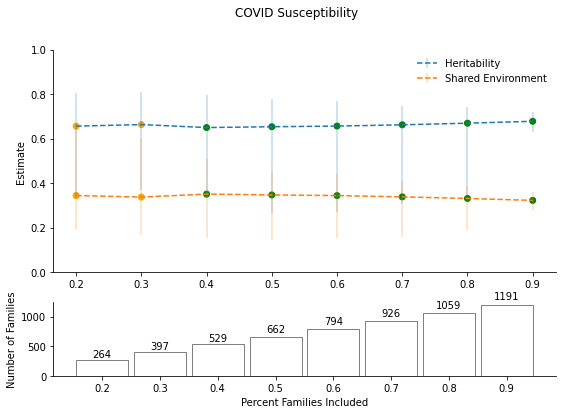

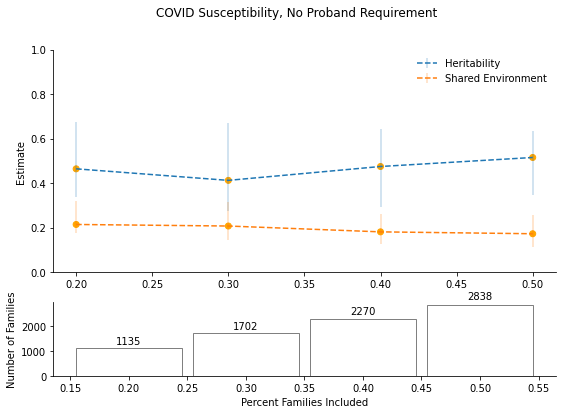

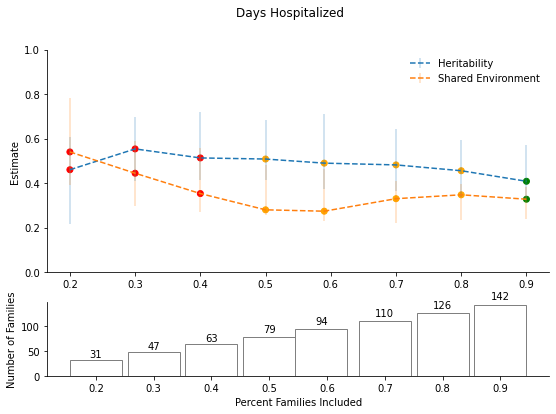

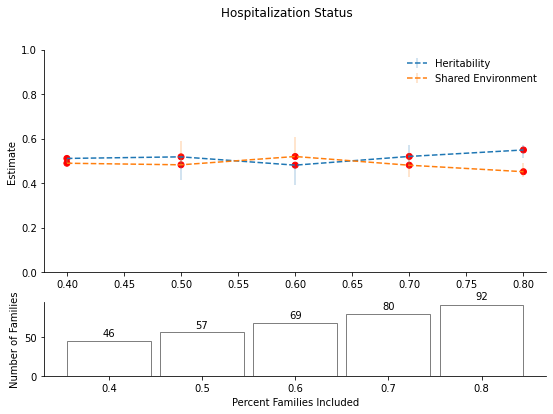

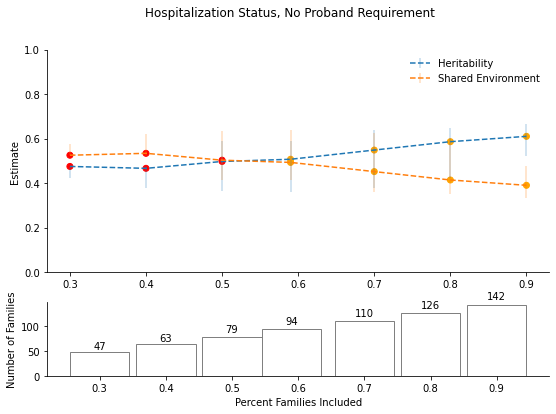

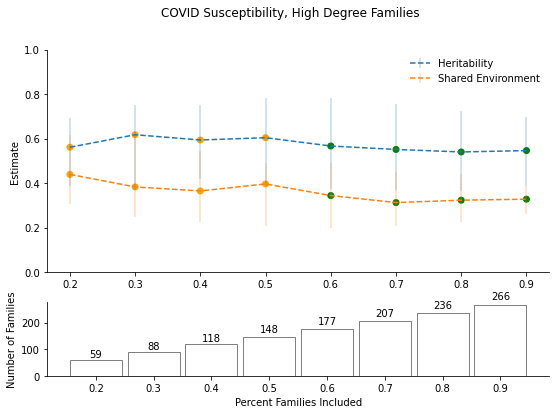

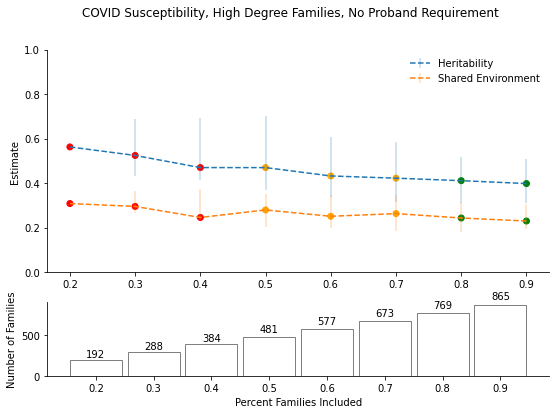

In [113]:
for pheno in phenos:
    
    #Partition by phenotype
    df_holder = solar_df[ solar_df["trait"] == pheno ].copy()
    
    #Assumes includes max 90% families for SOLARSTRAP
    num_total_fams = pheno2sampsize[pheno]
        

    #Calc percent fams included per solar iteration
    df_holder["fam_percent"] = df_holder["num_families"]/num_total_fams
    df_holder["fam_percent"].update( df_holder["fam_percent"].apply(round,ndigits=2) )
    
    
    #sort by the number of families 
    df_holder.sort_values(by="num_families",inplace=True)
    
    #get graph
    fig,axs = create_graph(df_holder,"fam_percent",clean_pheno_titles[pheno])


In [140]:
fig[0].axes[1]

<AxesSubplot:xlabel='Date Cutoff', ylabel='Number of Families'>

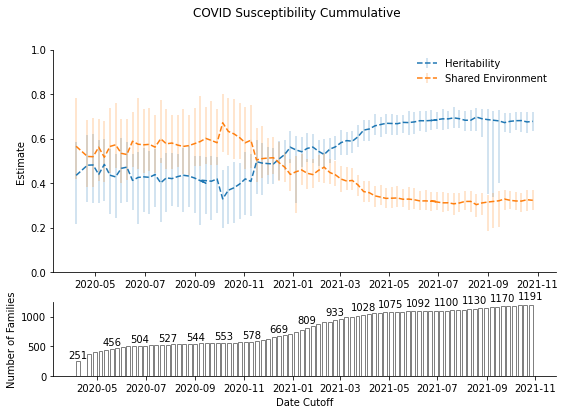

In [141]:
#Minimimum of 50 converged runs

#Partition by phenotype
df_holder = solar_df[ ( solar_df["trait"].str.contains( "covid_cswitch_weekly" ) == True ) ].copy()
df_holder = df_holder[ df_holder["num_converged"].astype(int) > 50 ]

#Pull date cases/controls are included through from phenotype name
df_holder["date"] = df_holder["trait"].apply( pull_date_window )

#sort by the number of families 
df_holder.sort_values(by="num_families",inplace=True)

#get graph
fig = create_graph(df_holder,"date","COVID Susceptibility Cummulative", remove_scatter_markers = True)

#     plt.show()

fig[0].axes[1].axvline(x = datetime(2020, 12, 14).date(), color = 'black', label = '1st vaccination in NYC ')
fig[0].axes[1].axvline(x = datetime(2021, 2, 14).date(), color = 'black', label = 'Vaccines available to patients with underlying conditions')
fig[0].axes[1].axvline(x = datetime(2021, 4, 6).date(), color = 'black', label = 'Vaccines available to patients 16+')
